## TODO
- start med student har samme arkitæktur som ensemble (kinda done)
- fix some of the plots for the ensemble that broke (i think they broke when changing size of the ensemble and or epochs)
- do more comparative analysis of the student model and ensemble

# Embed dataset:

In [62]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay, log_loss, f1_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import warnings 


In [63]:
# Check for GPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS device')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA device')
else:
    device = torch.device('cpu')
    print('No GPU found. Using CPU')

# Paths to save/load embeddings and labels
train_embeddings_file = 'train_embeddings.npy'
train_labels_file = 'train_labels.npy'
validation_embeddings_file = 'validation_embeddings.npy'
validation_labels_file = 'validation_labels.npy'
test_embeddings_file = 'test_embeddings.npy'
test_labels_file = 'test_labels.npy'

# Check if embeddings and labels are already saved
if (os.path.exists(train_embeddings_file) and os.path.exists(train_labels_file) and
    os.path.exists(validation_embeddings_file) and os.path.exists(validation_labels_file) and
    os.path.exists(test_embeddings_file) and os.path.exists(test_labels_file)):
    # Load embeddings and labels
    train_embeddings = np.load(train_embeddings_file)
    train_labels = np.load(train_labels_file)
    validation_embeddings = np.load(validation_embeddings_file)
    validation_labels = np.load(validation_labels_file)
    test_embeddings = np.load(test_embeddings_file)
    test_labels = np.load(test_labels_file)
    print("Loaded train, validation, and test embeddings and labels from disk.")
else:
    # Load model directly
    tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")
    model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")

    # Move the model to GPU
    model = model.to(device)

    # Load the SST-2 dataset from the GLUE benchmark with streaming
    dataset = load_dataset('glue', 'sst2', streaming=True)

    # Initialize lists to store embeddings and labels for each set
    train_embeddings_list = []
    train_labels_list = []
    validation_embeddings_list = []
    validation_labels_list = []
    test_embeddings_list = []
    test_labels_list = []

    # Function to extract embeddings
    def extract_embeddings(streamed_dataset, embeddings_list, labels_list):
        for example in tqdm(streamed_dataset):
            inputs = tokenizer(
                example['sentence'],
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=128
            ).to(device)
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # last layer hidden states
            embeddings = hidden_states.mean(dim=1).cpu().numpy()  # average over sequence length
            embeddings_list.append(embeddings.squeeze())  # shape (hidden_size,)
            labels_list.append(example['label'])

    # Extract embeddings for train, validation, and test sets
    extract_embeddings(dataset['train'], train_embeddings_list, train_labels_list)
    extract_embeddings(dataset['validation'], validation_embeddings_list, validation_labels_list)
    extract_embeddings(dataset['test'], test_embeddings_list, test_labels_list)

    # Convert lists to numpy arrays
    train_embeddings = np.vstack(train_embeddings_list)
    train_labels = np.array(train_labels_list)
    validation_embeddings = np.vstack(validation_embeddings_list)
    validation_labels = np.array(validation_labels_list)
    test_embeddings = np.vstack(test_embeddings_list)
    test_labels = np.array(test_labels_list)

    # Standardize the embeddings
    scaler = StandardScaler()
    train_embeddings = scaler.fit_transform(train_embeddings)
    validation_embeddings = scaler.transform(validation_embeddings)
    test_embeddings = scaler.transform(test_embeddings)

    # Save embeddings, labels, and scaler to disk
    np.save(train_embeddings_file, train_embeddings)
    np.save(train_labels_file, train_labels)
    np.save(validation_embeddings_file, validation_embeddings)
    np.save(validation_labels_file, validation_labels)
    np.save(test_embeddings_file, test_embeddings)
    np.save(test_labels_file, test_labels)

    print("Saved train, validation, and test embeddings and labels to disk.")

# Print shapes of embeddings and labels
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation embeddings shape: {validation_embeddings.shape}")
print(f"Validation labels shape: {validation_labels.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"Test labels shape: {test_labels.shape}")

Using MPS device
Loaded train, validation, and test embeddings and labels from disk.
Train embeddings shape: (67349, 2048)
Train labels shape: (67349,)
Validation embeddings shape: (872, 2048)
Validation labels shape: (872,)
Test embeddings shape: (1821, 2048)
Test labels shape: (1821,)


In [64]:
print(train_labels)

[0 0 1 ... 1 1 0]


In [65]:
train80_embeddings, distil_embeddings, train80_labels, distil_labels = train_test_split(
        train_embeddings, 
        train_labels, 
        test_size=0.20,       # This specifies that 20% of the data goes to the distil
        random_state=42,      # Ensures reproducibility
        stratify=train_labels # Ensures that the class distribution is preserved
    )

print(f"Train80 embeddings shape: {train80_embeddings.shape}")
print(f"Train80 labels shape: {train80_labels.shape}")
print(f"Distil embeddings shape: {distil_embeddings.shape}")
print(f"Distil labels shape: {distil_labels.shape}")

Train80 embeddings shape: (53879, 2048)
Train80 labels shape: (53879,)
Distil embeddings shape: (13470, 2048)
Distil labels shape: (13470,)


# Ensemble training

Training MLP 1/50
Validation -- Model 1: Accuracy = 0.8589, NLL = 0.3539, ECE = 0.0602, F1 = 0.8635
Validation -- Ensemble Size 1: Accuracy: 0.8589, NLL: 0.3539, ECE: 0.0602, F1 Score: 0.8589
Training MLP 2/50
Validation -- Model 2: Accuracy = 0.8521, NLL = 0.3588, ECE = 0.0698, F1 = 0.8584
Validation -- Ensemble Size 2: Accuracy: 0.8578, NLL: 0.3450, ECE: 0.0598, F1 Score: 0.8577
Training MLP 3/50
Validation -- Model 3: Accuracy = 0.8555, NLL = 0.3525, ECE = 0.0615, F1 = 0.8609
Validation -- Ensemble Size 3: Accuracy: 0.8567, NLL: 0.3392, ECE: 0.0563, F1 Score: 0.8566
Training MLP 4/50
Validation -- Model 4: Accuracy = 0.8624, NLL = 0.3704, ECE = 0.0582, F1 = 0.8664
Validation -- Ensemble Size 4: Accuracy: 0.8635, NLL: 0.3405, ECE: 0.0491, F1 Score: 0.8634
Training MLP 5/50
Validation -- Model 5: Accuracy = 0.8601, NLL = 0.3837, ECE = 0.0648, F1 = 0.8688
Validation -- Ensemble Size 5: Accuracy: 0.8635, NLL: 0.3419, ECE: 0.0492, F1 Score: 0.8634
Training MLP 6/50
Validation -- Model 6:

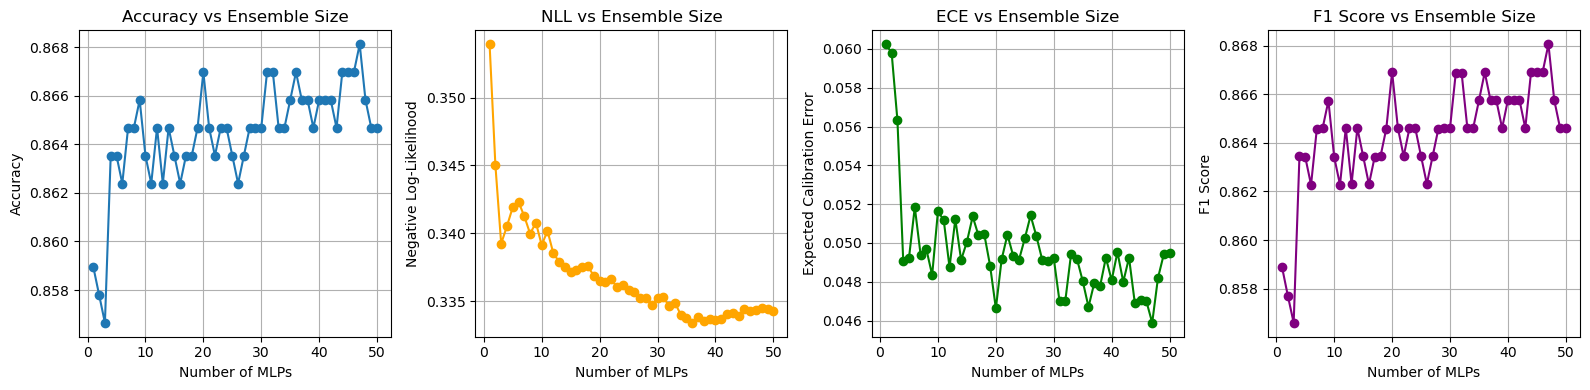

In [66]:
# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Number of MLPs in the ensemble
N = 50
batch_size = 2024
epochs = 10
hidden_size = 128

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, output_size=2):
        super(MLP, self).__init__()
        # Input layer to first hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # Optional dropout to help prevent overfitting
        self.dropout1 = nn.Dropout(p=0.5)
        # First hidden layer to second hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(p=0.5)
        # Second hidden layer to output layer
        self.fc3 = nn.Linear(hidden_dim2, output_size)
    
    def forward(self, x):
        # First hidden layer with ReLU activation
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        # Second hidden layer with ReLU activation
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        # Output layer
        x = self.fc3(x)
        # returns the logits
        return x

# Load your embeddings and labels (assuming they are already loaded)
# train_embeddings, train_labels, validation_embeddings, validation_labels, test_embeddings, test_labels

# Convert data to PyTorch tensors
# train_X = torch.from_numpy(train80_embeddings).float()
# train_y = torch.from_numpy(train80_labels).long()
train_X = torch.from_numpy(train_embeddings).float()
train_y = torch.from_numpy(train_labels).long()
val_X = torch.from_numpy(validation_embeddings).float()
val_y = torch.from_numpy(validation_labels).long()

# Create data loaders
train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

ensemble_models = []

# Metrics storage
ensemble_sizes = []
accuracies = []
nlls = []
eces = []
f1_list = []

# Function to compute Expected Calibration Error
def compute_ece(probs, labels, n_bins=10):
    """Compute Expected Calibration Error (ECE)."""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = predictions == labels
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

# Training and evaluation loop
for n in range(1, N + 1):
    print(f"Training MLP {n}/{N}")
    input_size = train_X.shape[1]
    model = MLP(input_size, hidden_size, output_size=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Train the model
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    # Evaluate the current individual model
    model.eval()
    with torch.no_grad():
        outputs = model(val_X.to(device))
        probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        
        single_probs = probs
        
        # Compute individual model metrics
        acc = accuracy_score(val_y.numpy(), preds)
        nll = log_loss(val_y.numpy(), probs)
        ece = compute_ece(probs, val_y.numpy())
        f1 = f1_score(val_y.numpy(),preds)
        
        print(f"Validation -- Model {n}: Accuracy = {acc:.4f}, NLL = {nll:.4f}, ECE = {ece:.4f}, F1 = {f1:.4f}")
    

    # Add the trained model to the ensemble
    ensemble_models.append(model)
    
    # Evaluate the ensemble up to the current number of models
    model.eval()
    with torch.no_grad():
        # Collect outputs from each model in the ensemble
        ensemble_outputs = []
        for m in ensemble_models:
            outputs = m(val_X.to(device))
            probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
            ensemble_outputs.append(probs)
        
        # Average the probabilities
        ensemble_probs = np.mean(ensemble_outputs, axis=0)
        ensemble_preds = np.argmax(ensemble_probs, axis=1)
        
        # Compute metrics
        acc = accuracy_score(val_y.numpy(), ensemble_preds)
        nll = log_loss(val_y.numpy(), ensemble_probs)
        ece = compute_ece(ensemble_probs, val_y.numpy())
        f1 = f1_score(val_y.numpy(), ensemble_preds, average='weighted')  # Using weighted averaging
        
        # Store metrics
        ensemble_sizes.append(n)
        accuracies.append(acc)
        nlls.append(nll)
        eces.append(ece)
        f1_list.append(f1)
        
        print(f"Validation -- Ensemble Size {n}: Accuracy: {acc:.4f}, NLL: {nll:.4f}, ECE: {ece:.4f}, F1 Score: {f1:.4f}")

# Plot metrics as a function of ensemble size
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(ensemble_sizes, accuracies, marker='o')
plt.title('Accuracy vs Ensemble Size')
plt.xlabel('Number of MLPs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(ensemble_sizes, nlls, marker='o', color='orange')
plt.title('NLL vs Ensemble Size')
plt.xlabel('Number of MLPs')
plt.ylabel('Negative Log-Likelihood')
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(ensemble_sizes, eces, marker='o', color='green')
plt.title('ECE vs Ensemble Size')
plt.xlabel('Number of MLPs')
plt.ylabel('Expected Calibration Error')
plt.grid(True)

# F1 Score Plot
plt.subplot(1, 4, 4)
plt.plot(ensemble_sizes, f1_list, marker='o', color='purple')
plt.title('F1 Score vs Ensemble Size')
plt.xlabel('Number of MLPs')
plt.ylabel('F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()


Har gjort MLPen dybere for at den ikke overfitter i distillation

### The method used above for ensemble prediction is averaging (Mean Voting)
   - **Description**: Each MLP produces a probability distribution over classes or a continuous output. The ensemble output is the average of these predictions.
   - **Application**: Commonly used for regression tasks or classification tasks where probabilities are averaged.
   - **Pros**: Simple to implement; works well when individual models are reasonably accurate and diverse.
   - **Cons**: Does not account for cases where some models are more accurate than others.


In [67]:
all_probs = []
for model in ensemble_models:
    model.eval()
    with torch.no_grad():
        outputs = model(inputs.to(device))
        probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
        all_probs.append(probs)

all_probs = np.stack(all_probs)  # Shape: (N_models, N_samples, N_classes)

# Predictive mean (averaged probabilities)
mean_probs = np.mean(all_probs, axis=0)

# Predictive variance (epistemic uncertainty)
variance_probs = np.var(all_probs, axis=0)

# Predictive entropy
entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-9), axis=1)


## Predictive Variance Histogram
Purpose: To see the distribution of uncertainties across all predictions.


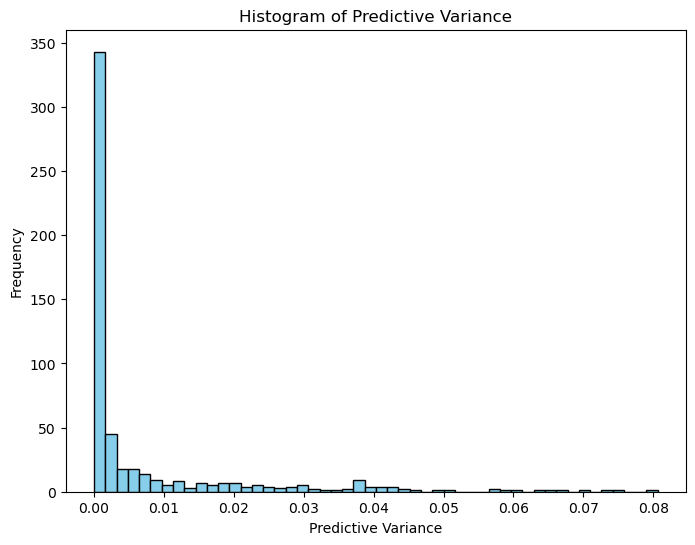

In [68]:
# Sum variances across classes if multi-class (for overall uncertainty)
total_variance = np.sum(variance_probs, axis=1)

plt.figure(figsize=(8, 6))
plt.hist(total_variance, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Predictive Variance')
plt.xlabel('Predictive Variance')
plt.ylabel('Frequency')
plt.show()





## Predictive Entropy Histogram
Purpose: Similar to variance, entropy gives a sense of uncertainty in predictions.



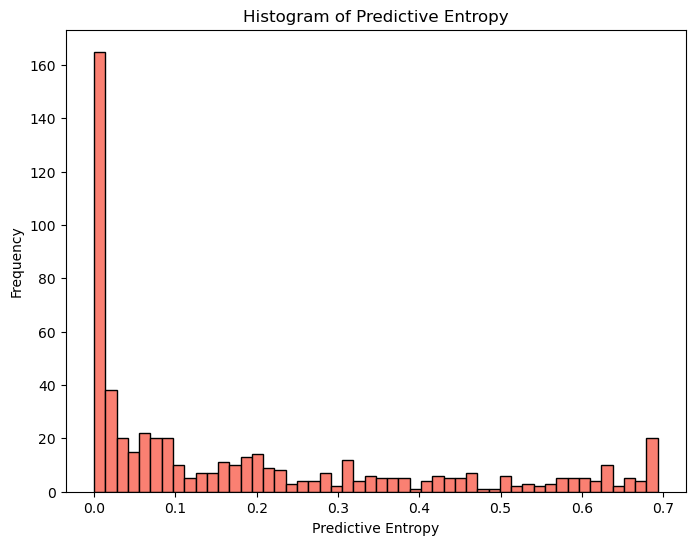

In [69]:

plt.figure(figsize=(8, 6))
plt.hist(entropy, bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of Predictive Entropy')
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.show()



## Scatter Plots of Uncertainty vs. Confidence

Purpose: To observe the relationship between model confidence and uncertainty.



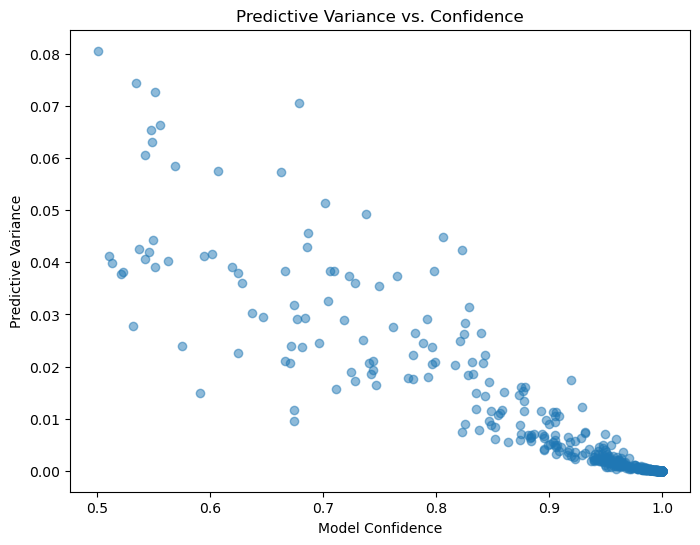

In [70]:

# Model confidence: max probability from mean_probs
confidence = np.max(mean_probs, axis=1)

# Total variance or entropy as uncertainty measure
total_variance = np.sum(variance_probs, axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(confidence, total_variance, alpha=0.5)
plt.title('Predictive Variance vs. Confidence')
plt.xlabel('Model Confidence')
plt.ylabel('Predictive Variance')
plt.show()



## Uncertainty vs. Correctness
Purpose: To check if higher uncertainties correspond to incorrect predictions.



In [71]:
# # Predicted labels
# predicted_labels = np.argmax(mean_probs, axis=1)

# # True labels
# true_labels = val_y.numpy()

# # Correct predictions
# correct = (predicted_labels == true_labels)

# # Total variance or entropy
# total_variance = np.sum(variance_probs, axis=1)

# plt.figure(figsize=(8, 6))
# plt.scatter(total_variance, correct, alpha=0.5, c=correct, cmap='bwr')
# plt.title('Predictive Variance vs. Correctness')
# plt.xlabel('Predictive Variance')
# plt.ylabel('Correct Prediction (1=True, 0=False)')
# plt.show()


## Reliability Diagram (Calibration Curve)
Purpose: To assess how well the predicted probabilities are calibrated.



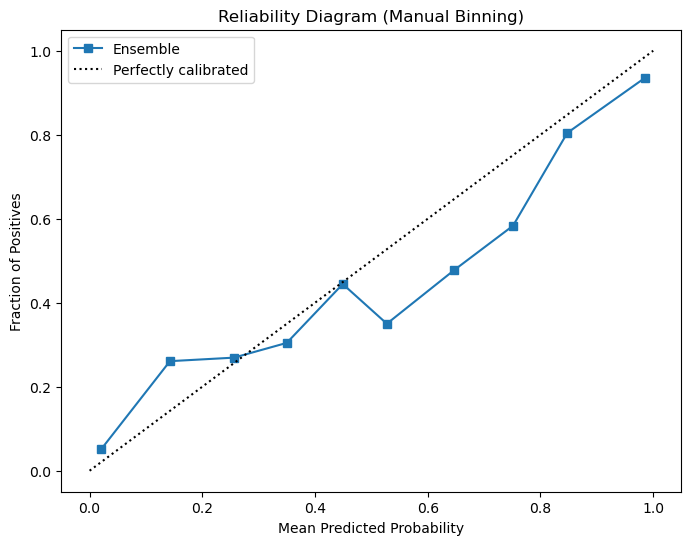

Bin counts: [294.  46.  26.  23.  27.  20.  23.  24.  46. 323.]


In [72]:
def plot_reliability_diagram(prob_pos, true_labels, n_bins=10):
    """
    Compute and plot a reliability diagram.
    
    Parameters:
    - prob_pos: 1D array of predicted probabilities for the positive class.
    - true_labels: 1D array of ground truth binary labels.
    - n_bins: Number of bins in the diagram.
    """
    # Define bins from 0 to 1
    bins = np.linspace(0, 1, n_bins + 1)
    
    # Arrays to store the bin means and fraction of positives
    bin_preds = np.zeros(n_bins)
    bin_true = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for i in range(n_bins):
        # Find samples with predictions in the current bin.
        indices = np.where((prob_pos >= bins[i]) & (prob_pos < bins[i+1]))[0]
        if len(indices) > 0:
            bin_preds[i] = np.mean(prob_pos[indices])
            bin_true[i] = np.mean(true_labels[indices])
            bin_counts[i] = len(indices)
    
    # Plot the reliability diagram
    plt.figure(figsize=(8, 6))
    plt.plot(bin_preds, bin_true, "s-", label="Ensemble")
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.title("Reliability Diagram (Manual Binning)")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.show()
    
    # Optionally print the bin counts for analysis
    print("Bin counts:", bin_counts)

# Example usage:
# Assume ensemble_probs is computed in your training loop as the averaged probability outputs on the validation set.
ensemble_prob_pos = ensemble_probs[:, 1]  # Extract probability for positive class
plot_reliability_diagram(ensemble_prob_pos, val_y.numpy(), n_bins=10)


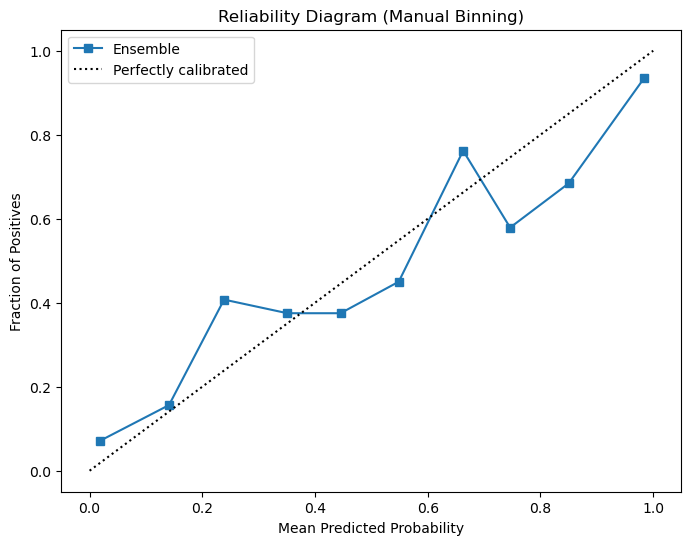

Bin counts: [325.  32.  27.  24.  16.  20.  21.  19.  38. 333.]


In [73]:
def plot_reliability_diagram(prob_pos, true_labels, n_bins=10):
    """
    Compute and plot a reliability diagram.
    
    Parameters:
    - prob_pos: 1D array of predicted probabilities for the positive class.
    - true_labels: 1D array of ground truth binary labels.
    - n_bins: Number of bins in the diagram.
    """
    # Define bins from 0 to 1
    bins = np.linspace(0, 1, n_bins + 1)
    
    # Arrays to store the bin means and fraction of positives
    bin_preds = np.zeros(n_bins)
    bin_true = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for i in range(n_bins):
        # Find samples with predictions in the current bin.
        indices = np.where((prob_pos >= bins[i]) & (prob_pos < bins[i+1]))[0]
        if len(indices) > 0:
            bin_preds[i] = np.mean(prob_pos[indices])
            bin_true[i] = np.mean(true_labels[indices])
            bin_counts[i] = len(indices)
    
    # Plot the reliability diagram
    plt.figure(figsize=(8, 6))
    plt.plot(bin_preds, bin_true, "s-", label="Ensemble")
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.title("Reliability Diagram (Manual Binning)")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.show()
    
    # Optionally print the bin counts for analysis
    print("Bin counts:", bin_counts)

# Example usage:
# Assume ensemble_probs is computed in your training loop as the averaged probability outputs on the validation set.
single_prob_pos = single_probs[:, 1]  # Extract probability for positive class
plot_reliability_diagram(single_prob_pos, val_y.numpy(), n_bins=10)


## Misclassification vs. Uncertainty
Highlight samples where the model is both uncertain and incorrect.



In [74]:
# # Identify misclassified samples with high uncertainty
# incorrect = (predicted_labels != true_labels)
# high_uncertainty = entropy > np.percentile(entropy, 75)  # Top 25% uncertainty

# misclassified_uncertain = incorrect & high_uncertainty

# # Print or visualize these samples
# print(f"Number of misclassified and highly uncertain samples: {np.sum(misclassified_uncertain)}")


## Comparative Plots Between Individual Models and Ensemble
Purpose: To show how the ensemble reduces uncertainty compared to individual models.



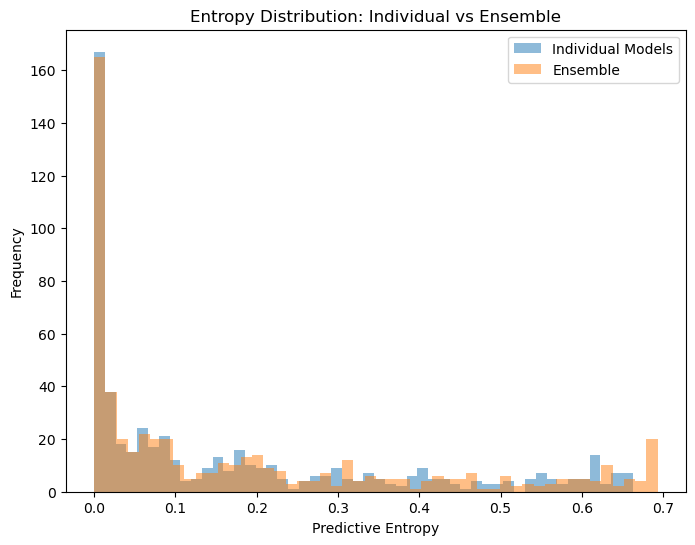

In [75]:
# Compute uncertainties for individual models
entropies_individual = []
for probs in all_probs:
    entropy_individual = -np.sum(probs * np.log(probs + 1e-9), axis=1)
    entropies_individual.append(entropy_individual) 

# Average individual entropies
mean_entropy_individual = np.mean(entropies_individual, axis=0)

# Plot comparison
plt.figure(figsize=(8, 6))
plt.hist(mean_entropy_individual, bins=50, alpha=0.5, label='Individual Models')
plt.hist(entropy, bins=50, alpha=0.5, label='Ensemble')
plt.title('Entropy Distribution: Individual vs Ensemble')
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.show()



Additional Tips:

- Interactive Visualizations: Use tools like Plotly or Bokeh for interactive plots that allow you to hover over data points to see exact values.
- Dimension Reduction: Apply techniques like t-SNE or UMAP to project high-dimensional data into 2D and color-code the points based on uncertainty.


In [76]:

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=0)
# embeddings_2d = tsne.fit_transform(val_X.numpy())

# plt.figure(figsize=(8, 6))
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=entropy, cmap='viridis', alpha=0.7)
# plt.colorbar(label='Predictive Entropy')
# plt.title('t-SNE Projection Colored by Uncertainty')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.show()


- 	Thresholding: Set thresholds for uncertainty measures to flag or further investigate certain predictions.

Integrating Visualizations into Your Workflow:

1.	Run the ensemble_uncertainty Function:

mean_probs, variance_probs, entropy = ensemble_uncertainty(ensemble_models, val_X, device)


2.	Choose Appropriate Visualizations:
- For overall understanding, start with histograms.
- To explore relationships, use scatter plots.
- For calibration, use reliability diagrams.
- For data with spatial structure, consider heatmaps.
3.	Interpret the Results:
- High Variance/Entropy: Indicates where the model is uncertain; consider investigating these samples.
- Calibration Curves: Help you understand if the probabilities reflect true likelihoods.
- Misclassifications with High Uncertainty: Potentially difficult samples or outliers.
4.	Refine the Model:
- Use insights from visualizations to improve data preprocessing, model architecture, or training strategies.
- Consider collecting more data in regions of high uncertainty.

Example Workflow:

Here’s how you might put it all together:


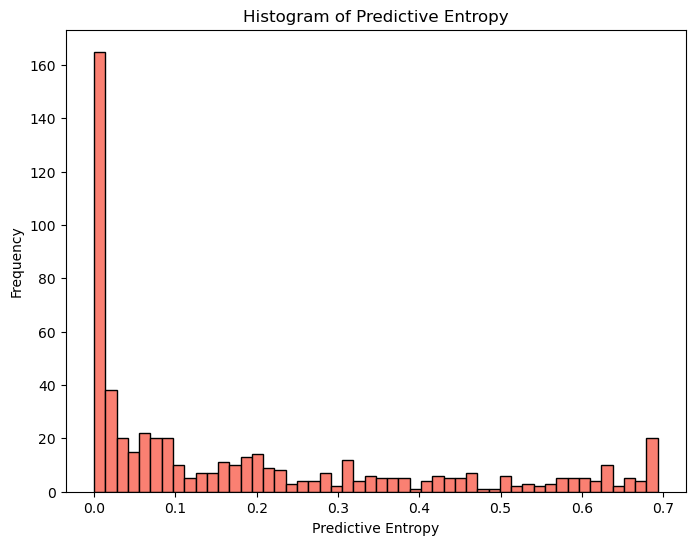

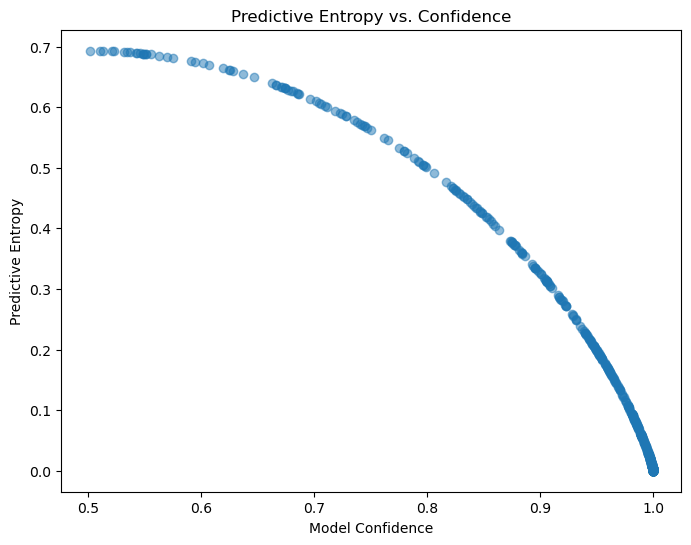

In [77]:

# Step 1: Compute Uncertainties
all_probs = []
for model in ensemble_models:
    model.eval()
    with torch.no_grad():
        outputs = model(inputs.to(device))
        probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
        all_probs.append(probs)

all_probs = np.stack(all_probs)  # Shape: (N_models, N_samples, N_classes)

# Predictive mean (averaged probabilities)
mean_probs = np.mean(all_probs, axis=0)

# Predictive variance (epistemic uncertainty)
variance_probs = np.var(all_probs, axis=0)

# Predictive entropy
entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-9), axis=1)

# Step 2: Visualize Histogram of Predictive Entropy
plt.figure(figsize=(8, 6))
plt.hist(entropy, bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of Predictive Entropy')
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.show()

# Step 3: Scatter Plot of Confidence vs. Predictive Entropy
confidence = np.max(mean_probs, axis=1)
plt.figure(figsize=(8, 6))
plt.scatter(confidence, entropy, alpha=0.5)
plt.title('Predictive Entropy vs. Confidence')
plt.xlabel('Model Confidence')
plt.ylabel('Predictive Entropy')
plt.show()

# Step 4: Reliability Diagram
# from sklearn.calibration import calibration_curve

# prob_pos = mean_probs[:, 1]
# fraction_of_positives, mean_predicted_value = calibration_curve(val_y.numpy(), prob_pos, n_bins=10)

# plt.figure(figsize=(8, 6))
# plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Ensemble")
# plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
# plt.title('Reliability Diagram')
# plt.xlabel('Mean Predicted Probability')
# plt.ylabel('Fraction of Positives')
# plt.legend()
# plt.show()



By employing these visualization techniques, you’ll gain a deeper understanding of where and why your model is uncertain. This can guide you in making informed decisions about model improvements, data collection, or even deploying the model in real-world scenarios where uncertainty estimation is critical.

Remember, the key is not just to compute uncertainty measures but to interpret them in the context of your specific problem and data.

# Distilation

Certainly! Knowledge distillation is a technique where a smaller model (student) is trained to replicate the behavior of a larger model or an ensemble of models (teacher). In your case, you can distill the knowledge from the ensemble of MLP models into a single MLP model.

Here’s how you can proceed:
	1.	Generate Soft Targets: Use the ensemble to generate probability distributions (soft labels) for the training data.
	2.	Train the Student Model: Train a single MLP model using these soft targets, minimizing the difference between the student’s outputs and the soft targets from the ensemble.
	3.	Implement Distillation Loss: Use a combination of cross-entropy loss with the true labels and Kullback-Leibler (KL) divergence loss with the soft labels.

Below is the complete code integrating knowledge distillation into your existing setup.

Step-by-Step Guide

1. Generate Soft Targets from the Ensemble

- Use the trained ensemble models to generate the averaged probabilities (mean of softmax outputs) for the training data.

2. Define the Student Model

- Create a new MLP model that will serve as the student.

3. Implement the Distillation Loss Function

- Use a custom loss function that combines the standard cross-entropy loss with the KL divergence between the student’s outputs and the soft targets.
- Introduce a temperature parameter T to soften the probabilities.

4. Train the Student Model

- Train the student model on the training data using the distillation loss.
- Monitor the validation performance.



Epoch 1/50, Loss: 0.2678
Validation -- Accuracy: 0.8498, NLL: 0.3443, ECE: 0.0310, F1 Score: 0.8497
Epoch 2/50, Loss: 0.1560
Validation -- Accuracy: 0.8578, NLL: 0.3300, ECE: 0.0336, F1 Score: 0.8574
Epoch 3/50, Loss: 0.1285
Validation -- Accuracy: 0.8612, NLL: 0.3213, ECE: 0.0367, F1 Score: 0.8612
Epoch 4/50, Loss: 0.1117
Validation -- Accuracy: 0.8670, NLL: 0.3273, ECE: 0.0458, F1 Score: 0.8668
Epoch 5/50, Loss: 0.1010
Validation -- Accuracy: 0.8681, NLL: 0.3326, ECE: 0.0430, F1 Score: 0.8680
Epoch 6/50, Loss: 0.0931
Validation -- Accuracy: 0.8658, NLL: 0.3376, ECE: 0.0498, F1 Score: 0.8657
Epoch 7/50, Loss: 0.0865
Validation -- Accuracy: 0.8681, NLL: 0.3365, ECE: 0.0469, F1 Score: 0.8681
Epoch 8/50, Loss: 0.0811
Validation -- Accuracy: 0.8635, NLL: 0.3447, ECE: 0.0488, F1 Score: 0.8634
Epoch 9/50, Loss: 0.0779
Validation -- Accuracy: 0.8624, NLL: 0.3475, ECE: 0.0523, F1 Score: 0.8623
Epoch 10/50, Loss: 0.0748
Validation -- Accuracy: 0.8635, NLL: 0.3494, ECE: 0.0554, F1 Score: 0.8634

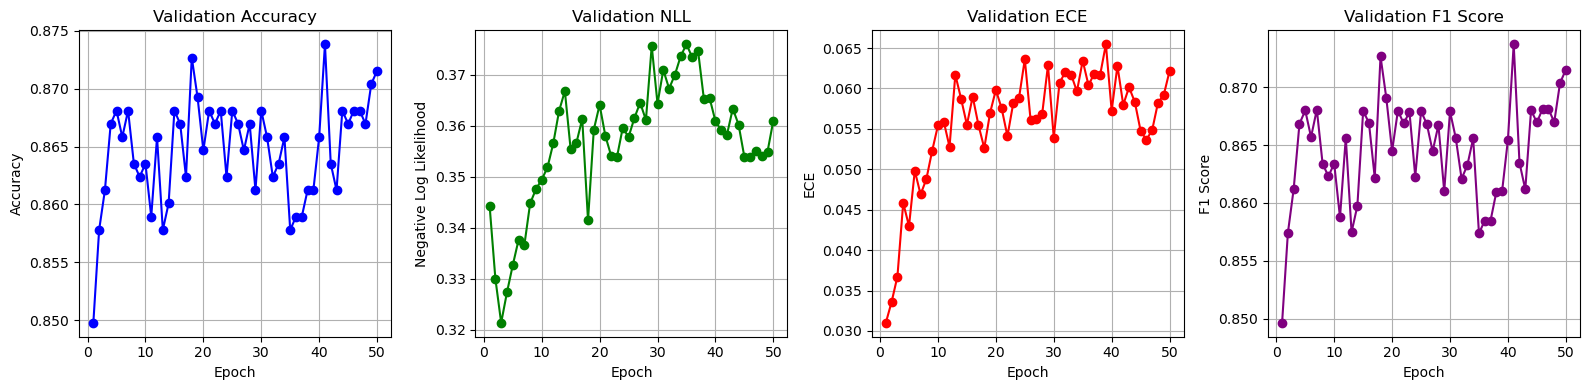

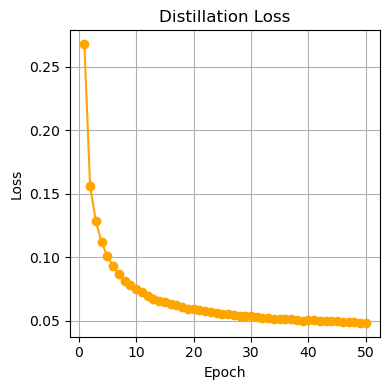

In [78]:
# Step 1: Generate Soft Targets from the Ensemble for Training Data
def generate_soft_targets(ensemble_models, train_X):
    all_probs = []
    train_X = train_X.to(device)
    for model in ensemble_models:
        model.eval()
        model.to(device)
        with torch.no_grad():
            outputs = model(train_X)
            probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
        model.cpu()
    all_probs = np.stack(all_probs)  # Shape: (N_models, N_samples, N_classes)
    soft_targets = np.mean(all_probs, axis=0)
    return soft_targets

# Generate soft targets
soft_targets = generate_soft_targets(ensemble_models, train_X)

# Step 2: Define the Student Model - Using the same architecture as models in the Ensemble
class StudentMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, output_size=2):
        super(StudentMLP, self).__init__()
        # Input layer to first hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # Optional dropout to help prevent overfitting
        self.dropout1 = nn.Dropout(p=0.5)
        # First hidden layer to second hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(p=0.5)
        # Second hidden layer to output layer
        self.fc3 = nn.Linear(hidden_dim2, output_size)
    
    def forward(self, x):
        # First hidden layer with ReLU activation
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        # Second hidden layer with ReLU activation
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        # Output layer
        x = self.fc3(x)
        # returns the logits
        return x

# Step 3: Implement the Distillation Loss Function
def distillation_loss(y_student_logits, y_true_labels, y_teacher_probs, T=2.0, alpha=0.7):
    """
    y_student_logits: Logits output by the student model
    y_true_labels: Ground truth labels
    y_teacher_probs: Soft targets (probabilities) from the teacher (ensemble)
    T: Temperature parameter
    alpha: Weighting factor between soft and hard targets
    """
    # Cross-Entropy Loss with true labels (hard targets)
    ce_loss = nn.CrossEntropyLoss()(y_student_logits, y_true_labels)
    
    # KL Divergence Loss with soft targets (from teacher)
    log_student_probs = nn.functional.log_softmax(y_student_logits / T, dim=1)
    teacher_probs_T = torch.tensor(y_teacher_probs, dtype=torch.float32).to(y_student_logits.device)
    kl_loss = nn.KLDivLoss(reduction='batchmean')(log_student_probs, teacher_probs_T)
    
    # Combined Loss
    loss = alpha * ce_loss + (1 - alpha) * (T ** 2) * kl_loss
    loss = alpha
    return loss

# Step 4: Train the Student Model with Evaluation Metrics Collected at Each Epoch
def train_student_model(student_model, train_loader, val_X, val_y, soft_targets, epochs=50, T=2.0, alpha=0.7):
    student_model.to(device)
    optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
    loss_plot = []
    
    # Lists to keep track of evaluation metrics on the validation set
    acc_list = []
    nll_list = []
    ece_list = []
    f1_list = []  # New list to store F1 score
    
    # Convert soft_targets to tensor for easier batch extraction later
    soft_targets_tensor = torch.tensor(soft_targets, dtype=torch.float32)
    
    for epoch in range(epochs):
        student_model.train()
        epoch_losses = []
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = student_model(inputs)  # Logits
            # Map the soft targets to the current batch using indices
            batch_start = batch_idx * train_loader.batch_size
            batch_end = batch_start + inputs.size(0)
            y_teacher_probs = soft_targets_tensor[batch_start:batch_end].to(device)
            
            # Compute the distillation loss
            loss = distillation_loss(outputs, labels, y_teacher_probs, T=T, alpha=alpha)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        loss_plot.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
        # Set model to evaluation mode and compute metrics on validation set
        student_model.eval()
        with torch.no_grad():
            val_outputs = student_model(val_X.to(device))
            val_probs = nn.functional.softmax(val_outputs, dim=1).cpu().numpy()
            val_preds = np.argmax(val_probs, axis=1)
            
            # Calculate Accuracy, NLL, ECE, and F1 score on validation data
            acc = accuracy_score(val_y.numpy(), val_preds)
            nll = log_loss(val_y.numpy(), val_probs)
            ece = compute_ece(val_probs, val_y.numpy())
            f1 = f1_score(val_y.numpy(), val_preds, average='weighted')  # Using weighted averaging
            
            acc_list.append(acc)
            nll_list.append(nll)
            ece_list.append(ece)
            f1_list.append(f1)
        
        print(f"Validation -- Accuracy: {acc:.4f}, NLL: {nll:.4f}, ECE: {ece:.4f}, F1 Score: {f1:.4f}")
    
    # Plot the evaluation metrics
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(16, 4))
    
    # Accuracy Plot
    plt.subplot(1, 4, 1)
    plt.plot(epochs_range, acc_list, marker='o', color='blue')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # NLL Plot
    plt.subplot(1, 4, 2)
    plt.plot(epochs_range, nll_list, marker='o', color='green')
    plt.title('Validation NLL')
    plt.xlabel('Epoch')
    plt.ylabel('Negative Log Likelihood')
    plt.grid(True)
    
    # ECE Plot
    plt.subplot(1, 4, 3)
    plt.plot(epochs_range, ece_list, marker='o', color='red')
    plt.title('Validation ECE')
    plt.xlabel('Epoch')
    plt.ylabel('ECE')
    plt.grid(True)
    
    # F1 Score Plot
    plt.subplot(1, 4, 4)
    plt.plot(epochs_range, f1_list, marker='o', color='purple')
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(4, 4))
    # Loss Plot
    plt.plot(epochs_range, loss_plot, marker='o', color='orange')
    plt.title('Distillation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return student_model, loss_plot

# --- Data Preparation ---

# For the sake of this example, we assume that train_X, train_y, val_X, val_y, ensemble_models, device,
# hidden_size, and batch_size are already defined from previous steps.
# Convert data to PyTorch tensors
train_X = torch.from_numpy(train_embeddings).float()
train_y = torch.from_numpy(train_labels).long()

# Prepare DataLoader with indices to match soft targets
train_dataset_with_indices = TensorDataset(train_X, train_y)
train_loader_with_indices = DataLoader(train_dataset_with_indices, batch_size=batch_size, shuffle=False)

# Instantiate the student model
student_model = StudentMLP(input_dim=train_X.shape[1], output_size=2)

# Set the number of epochs
epochs = 50

# Ignore warnings of a specific category
warnings.filterwarnings('ignore', category=UserWarning)

student_model, loss_plot = train_student_model(
    student_model,
    train_loader_with_indices,
    val_X,
    val_y,
    soft_targets,
    epochs=epochs,
    T=1.0,
    alpha=0.3
)

# Re-enable warnings by clearing or overriding the filter
warnings.filterwarnings('default', category=UserWarning)



Explanation

- Temperature (T): A higher temperature softens the probability distribution, making the model pay more attention to less probable classes. It’s common to set T=2.0 or higher.
- Alpha (alpha): Balances the importance between the hard targets (true labels) and the soft targets (ensemble outputs). Adjusting alpha allows you to emphasize either the true labels or the knowledge from the ensemble.
- DataLoader Modification: We ensure that the data loader does not shuffle the data so that the indices of the soft targets align with the batches.

Notes

- Device Management: Ensure that all tensors and models are on the same device during training and inference.
- Memory Considerations: Storing soft targets for the entire dataset may consume significant memory for large datasets. If this is an issue, consider generating soft targets on-the-fly during training.
- Performance Evaluation: After training, compare the performance of the student model with the ensemble and individual models to assess the effectiveness of distillation.



In [79]:
# Paths to save/load embeddings and labels
imdb_train_embeddings_file = 'imdb_train_embeddings.npy'
imdb_train_labels_file = 'imdb_train_labels.npy'
# imdb_test_embeddings_file = 'imdb_test_embeddings.npy'
# imdb_test_labels_file = 'imdb_test_labels.npy'
# imdb_unsupervised_embeddings_file = 'imdb_unsupervised_embeddings.npy'
# imdb_unsupervised_labels_file = 'imdb_unsupervised_labels.npy'

# Check if embeddings and labels are already saved
if (os.path.exists(imdb_train_embeddings_file) and os.path.exists(imdb_train_labels_file)):
    # and
    # os.path.exists(imdb_test_embeddings_file) and os.path.exists(imdb_test_labels_file) and
    # os.path.exists(imdb_unsupervised_embeddings_file) and os.path.exists(imdb_unsupervised_labels_file)
    # Load embeddings and labels
    imdb_train_embeddings = np.load(imdb_train_embeddings_file)
    imdb_train_labels = np.load(imdb_train_labels_file)
    # imdb_test_embeddings = np.load(imdb_test_embeddings_file)
    # imdb_test_labels = np.load(imdb_test_labels_file)
    # imdb_unsupervised_embeddings = np.load(imdb_unsupervised_embeddings_file)
    # imdb_unsupervised_labels = np.load(imdb_unsupervised_labels_file)
    print("Loaded train, validation, and test embeddings and labels from disk.")
else:
    # Load model directly
    tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")
    model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")

    # Move the model to GPU
    model = model.to(device)


    # Load the SST-2 dataset from the GLUE benchmark with streaming
    dataset = load_dataset("stanfordnlp/imdb", streaming=True, split='train')

    # Initialize lists to store embeddings and labels for each set
    imdb_train_embeddings_list = []
    imdb_train_labels_list = []
    imdb_test_embeddings_list = []
    imdb_test_labels_list = []
    imdb_unsupervised_embeddings_list = []
    imdb_unsupervised_labels_list = []

    # Function to extract embeddings
    def extract_embeddings(streamed_dataset, embeddings_list, labels_list):
        for example in tqdm(streamed_dataset):
            inputs = tokenizer(
                example['text'],
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=128
            ).to(device)
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # last layer hidden states
            embeddings = hidden_states.mean(dim=1).cpu().numpy()  # average over sequence length
            embeddings_list.append(embeddings.squeeze())  # shape (hidden_size,)
            labels_list.append(example['label'])

    # Extract embeddings for train, validation, and test sets
    extract_embeddings(dataset, imdb_train_embeddings_list, imdb_train_labels_list)
    # extract_embeddings(dataset['test'], imdb_test_embeddings_list, imdb_test_labels_list)
    # extract_embeddings(dataset['unsupervised'], imdb_unsupervised_embeddings_list, imdb_unsupervised_labels_list)

    # Convert lists to numpy arrays
    imdb_train_embeddings = np.vstack(imdb_train_embeddings_list)
    imdb_train_labels = np.array(imdb_train_labels_list)
    # imdb_test_embeddings = np.vstack(imdb_test_embeddings_list)
    # imdb_test_labels = np.array(imdb_test_labels_list)
    # imdb_unsupervised_embeddings = np.vstack(imdb_unsupervised_embeddings_list)
    # imdb_unsupervised_labels = np.array(imdb_unsupervised_labels_list)

    # Standardize the embeddings
    scaler = StandardScaler()
    imdb_train_embeddings = scaler.fit_transform(imdb_train_embeddings)
    # imdb_test_embeddings = scaler.transform(imdb_test_embeddings)
    # imdb_unsupervised_embeddings = scaler.transform(imdb_unsupervised_embeddings)

    # Save embeddings, labels, and scaler to disk
    np.save(imdb_train_embeddings_file, imdb_train_embeddings)
    np.save(imdb_train_labels_file, imdb_train_labels)
    # np.save(imdb_test_embeddings_file, imdb_test_embeddings)
    # np.save(imdb_test_labels_file, imdb_test_labels)
    # np.save(imdb_unsupervised_embeddings_file, imdb_unsupervised_embeddings)
    # np.save(imdb_unsupervised_labels_file, imdb_unsupervised_labels)

    print("Saved train, test, and unsupervised embeddings and labels to disk.")

# Print shapes of embeddings and labels
print(f"IMDB Train embeddings shape: {imdb_train_embeddings.shape}")
print(f"IMDB Train labels shape: {imdb_train_labels.shape}")
# print(f"IMDB Test embeddings shape: {imdb_test_embeddings.shape}")
# print(f"IMDB Test labels shape: {imdb_test_labels.shape}")
# print(f"IMDB Unsupervised embeddings shape: {imdb_unsupervised_embeddings.shape}")
# print(f"IMDB Unsupervised labels shape: {imdb_unsupervised_labels.shape}")

Loaded train, validation, and test embeddings and labels from disk.
IMDB Train embeddings shape: (25000, 2048)
IMDB Train labels shape: (25000,)


In [80]:
imdb_train_X = torch.from_numpy(imdb_train_embeddings).float()
imdb_train_y = torch.from_numpy(imdb_train_labels).long()

# Prepare DataLoader with indices to match soft targets
train_dataset_with_indices = TensorDataset(imdb_train_X, imdb_train_y)
train_loader_with_indices = DataLoader(train_dataset_with_indices, batch_size=batch_size, shuffle=False)

student_model.eval()
with torch.no_grad():
            val_outputs = student_model(imdb_train_X.to(device))
            val_probs = nn.functional.softmax(val_outputs, dim=1).cpu().numpy()
            val_preds = np.argmax(val_probs, axis=1)
            
            # Calculate Accuracy, NLL, ECE, and F1 score on validation data
            acc = accuracy_score(imdb_train_y.numpy(), val_preds)
            nll = log_loss(imdb_train_y.numpy(), val_probs)
            ece = compute_ece(val_probs, imdb_train_y.numpy())
            f1 = f1_score(imdb_train_y.numpy(), val_preds, average='weighted')  # Using weighted averaging

print(f"Accuracy: {acc:.4f}, NLL: {nll:.4f}, ECE: {ece:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.8229, NLL: 0.5432, ECE: 0.0965, F1 Score: 0.8222


In [81]:

all_probs = []
train_X = imdb_train_X.to(device)
for model in ensemble_models:
    model.eval()
    model.to(device)
    with torch.no_grad():
        outputs = model(train_X)
        probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
        all_probs.append(probs)
    model.cpu()
    
ensemble_probs = np.stack(all_probs, axis=0)  # Shape: (N_models, N_samples, N_classes)
ensemble_preds = np.argmax(ensemble_probs, axis=1)
print(ensemble_preds.shape(0))
# Compute metrics
acc = accuracy_score(imdb_train_y.numpy(), ensemble_preds)
nll = log_loss(imdb_train_y.numpy(), ensemble_probs)
ece = compute_ece(ensemble_probs, imdb_train_y.numpy())
f1 = f1_score(imdb_train_y.numpy(), ensemble_preds, average='weighted')  # Using weighted averaging



TypeError: 'tuple' object is not callable

In [54]:
model.eval()
with torch.no_grad():
        for m in ensemble_models:
                outputs = m(imdb_train_X.to(device))
                probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
                ensemble_outputs.append(probs)
        
        # Average the probabilities
        ensemble_probs = np.mean(ensemble_outputs, axis=0)
        ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Compute metrics
acc = accuracy_score(imdb_train_y.numpy(), ensemble_preds)
nll = log_loss(imdb_train_y.numpy(), ensemble_probs)
ece = compute_ece(ensemble_probs, imdb_train_y.numpy())
f1 = f1_score(imdb_train_y.numpy(), ensemble_preds, average='weighted')  # Using weighted averaging

RuntimeError: Placeholder storage has not been allocated on MPS device!